# Supervised Machine Learning To Detect Fraud

Industries and individuals are suffering from fraudulent damages. Fraud can be define as money or property being obtained through false pretenses. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. 

In this project, we will use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 

* 	Supervised: The goal is to train a model to learn from features to predict the probability of an online               fraudulent transaction given labels in the isFraud column. 
* 	Classification: The label is a binary variable: 0 (not fraud), 1 (fraud)


# Overview of Data

There are a total of 2 files: 
* 	1 transaction files 
* 	2 identity files 
We will be merging train transaction and train identity to gain more information regarding detecting fraud.

Transaction Table

* 	TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* 	TransactionAMT: transaction payment amount in USD
* 	ProductCD: product code, the product for each transaction
* 	card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* 	addr: address
* 	dist: distance
* 	P_ and (R__) emaildomain: purchaser and recipient email domain
* 	C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* 	D1-D15: timedelta, such as days between previous transaction, etc.
* 	M1-M9: match, such as names on card and address, etc.
* 	Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* 	Categorical Features:
* 	ProductCD
* 	card1 - card6
* 	addr1, addr2
* 	Pemaildomain Remaildomain
* 	M1 - M9

Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:

* 	DeviceType
* 	DeviceInfo
* 	id12 - id38


Workflow

1.	Understand the problem (we're almost there already)
2.	Exploratory Data Analysis
3.	Feature engineering to create a dataset for machine learning
4.	Create a baseline machine learning model
5.	Optimize the models
6.	Investigate model predictions in context of problem
7.	Draw conclusions and lay out next steps


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

In [2]:
train_identity = pd.read_csv(r'H:\train_identity.csv')
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [3]:
train_transaction = pd.read_csv(r'H:\train_transaction.csv')
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#checking the shape of each data frame
print(train_identity.shape,train_transaction.shape)

(144233, 41) (590540, 394)


In [5]:
#merge two data frame
train = pd.merge(train_transaction,train_identity, on = "TransactionID", how="left" )
print( "Training Data shape : ", train.shape)
train.head()

Training Data shape :  (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
#Data types
train.info(verbose=True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 434 columns):
TransactionID     590540 non-null int64
isFraud           590540 non-null int64
TransactionDT     590540 non-null int64
TransactionAmt    590540 non-null float64
ProductCD         590540 non-null object
card1             590540 non-null int64
card2             581607 non-null float64
card3             588975 non-null float64
card4             588963 non-null object
card5             586281 non-null float64
card6             588969 non-null object
addr1             524834 non-null float64
addr2             524834 non-null float64
dist1             238269 non-null float64
dist2             37627 non-null float64
P_emaildomain     496084 non-null object
R_emaildomain     137291 non-null object
C1                590540 non-null float64
C2                590540 non-null float64
C3                590540 non-null float64
C4                590540 non-null float64
C5                59

In [7]:
num_var = train.select_dtypes(['int64','float64']).columns
print("There are {} numeric variables".format(len(num_var)))

cat_var = train.select_dtypes(['object']).columns
print("There are {} categorical variables".format(len(cat_var)))

There are 403 numeric variables
There are 31 categorical variables


In [8]:
# display max columns
pd.set_option('display.max_columns', None)

In [9]:
#Exploratory Data Analysis

train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [10]:
train.describe(include=['object'])

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288,144233,140985,129340,5169,5169,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2,2,3,2,3,2,2,2,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656,123025,67728,66324,3489,5155,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


In [11]:
#working on a copy of a data frame
df = train.copy()
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [12]:
#drop TransactionID
df.drop(['TransactionID'], axis=1, inplace=True)

In [13]:
#Missing Values

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [14]:
missing_values_table(df)

Your selected dataframe has 433 columns.
There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
id_26,585377,99.1
id_27,585371,99.1
id_23,585371,99.1
id_22,585371,99.1
dist2,552913,93.6


Oberved that there are missing values in majority columns. Due to the limied information given on these columns for privacy issues, it is difficult to determine if these columns offer healpful information for predicting fraud.

I will drop columns mssing more than 25% of data points. Then I will impute numerical variables by mean and categorical variables by mode.

In [15]:
# Get the columns with >= 25% missing

missing_df = missing_values_table(train)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 25].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 434 columns.
There are 414 columns that have missing values.
We will remove 252 columns.


In [16]:
df.drop(missing_columns, axis=1, inplace=True)

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    def _init_(self):
        "Impute Missing Values. Object data types with mode, numerical data types with mean."
        
    def fit(self, X, y=None):
        
        self.fill = pd.Series([X[c].value_counts().index[0]
                             if X[c].dtype == np.dtype('O')
                             else X[c].mean() for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
df = DataFrameImputer().fit_transform(df)

In [19]:
missing_values_table(df)

Your selected dataframe has 181 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Removing Outliers

Set the threshold at 3 standard deviations as it will allow us to retain 99% of the data set. 

In [20]:
#Function to detect extream values and replcae with threshold value

def outlier_table(df):
    for column in df.select_dtypes(['int64','float64']).columns:
        if df[column].quantile(0.997)<df[column].max():
            threshold = df[column].quantile(0.997)
            df[column] = np.where(df[column]> threshold, int(round(threshold)), df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column]< threshold, int(round(threshold)), df[column])
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column]< threshold, int(round(threshold)), df[column])
        else:
            pass
    return df

In [21]:
df = outlier_table(df)

In [22]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [23]:
df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.0,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,7.372258e+06,133.083889,9898.667220,362.547244,153.134612,199.270002,290.719834,86.790199,10.411088,11.312341,0.004113,2.285268,5.477702,7.271367,0.382746,2.201558,4.398537,2.074723,7.661955,0.756462,30.530328,7.084782,94.331988,123.895977,163.633724,0.559508,0.598378,0.999500,0.121412,0.121595,0.130120,0.133367,0.815577,0.844764,0.128886,0.129281,1.032329,1.054822,0.977303,0.986965,0.000100,0.000107,0.387043,0.402489,0.139076,0.139335,0.129780,0.137271,0.577283,0.618612,1.062797,1.111159,0.127843,0.130791,0.132259,0.138094,0.828098,0.865805,0.130075,0.138773,0.999663,0.980301,0.996126,0.000070,0.389259,0.403966,0.139963,0.143073,0.139354,0.150787,0.544021,0.586267,1.07922,1.130816,0.1

Not much changed by the average transaction dropped from 135 Dollers to 133 Dollers

Examine Target Variable

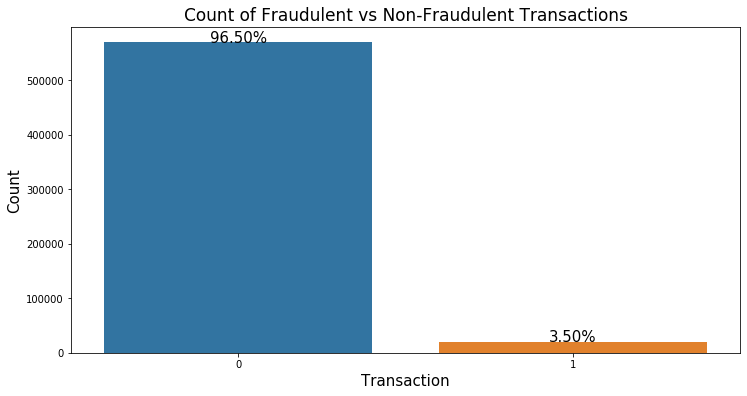

In [24]:
#plot target variable

plt.figure(figsize=(12,6))
g = sns.countplot(x='isFraud', data = df)
g.set_title('Count of Fraudulent vs Non-Fraudulent Transactions', fontsize = 17)
g.set_xlabel('Transaction', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2, height +3, '{:1.2f}%'.format(height/len(df)*100), ha="center", fontsize = 15)


The fraud rate is 3.5% in the transaction dataset. According to the histogram, can see an imbalanced class from the value count. Need to apply sampling based approaches to mitigate this.

Multivariate Analysis

 Correlation

In [25]:
# Find correlations with the target and sort
corr = df.corr()['isFraud'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 V16        0.160311
V15        0.160320
V80        0.160874
V74        0.161232
V34        0.164261
C7         0.164455
V33        0.164666
V93        0.165097
V81        0.165820
V94        0.168004
V79        0.176910
V87        0.210706
V86        0.220593
isFraud    1.000000
V305            NaN
Name: isFraud, dtype: float64

Most Negative Correlations:
 V90   -0.099197
V29   -0.098086
V91   -0.097009
V30   -0.095680
V69   -0.093511
V70   -0.091915
D15   -0.069168
D1    -0.067128
D10   -0.064979
V12   -0.047628
V75   -0.046888
V76   -0.044732
V13   -0.043669
V53   -0.042079
V54   -0.035861
Name: isFraud, dtype: float64


In [26]:
#correlation
top_feat = np.absolute(df.corr()['isFraud']).sort_values(ascending=False)[:11]
top_feat

isFraud    1.000000
V86        0.220593
V87        0.210706
V79        0.176910
V94        0.168004
V81        0.165820
V93        0.165097
V33        0.164666
C7         0.164455
V34        0.164261
V74        0.161232
Name: isFraud, dtype: float64

In [27]:
#top 10 features
print(top_feat.index)

Index(['isFraud', 'V86', 'V87', 'V79', 'V94', 'V81', 'V93', 'V33', 'C7', 'V34',
       'V74'],
      dtype='object')


In [28]:
#  pp = df[top_feat.index]

#  sns.set(font_scale=1.7)
#  sns.pairplot(pp)
#  plt.show()

In [29]:
#  plt.figure(figsize=(10,9))
#  corr = pp.corr()
#  sns.heatmap(corr)
#  plt.savefig('heatmap.png')

## Transaction Amount

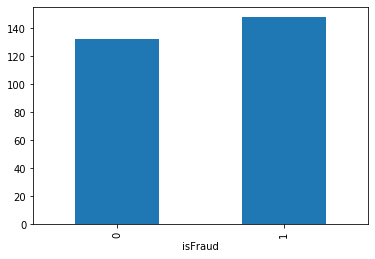

In [30]:
df.groupby('isFraud')['TransactionAmt'].mean().plot(kind='bar')

From this chart, we can see that the average transaction amount for fraudulent activities are higher than normal transactions.

### Examine Card Type

Which card has the highest fraud rate?

In [31]:
#Check what are the data in Card1 to Card6 columns
card_cols = [c for c in df.columns if 'card' in c]
df[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,362.555488,150.0,discover,142.0,credit
1,2755,404.000000,150.0,mastercard,102.0,credit
2,4663,490.000000,150.0,visa,166.0,debit
3,18132,567.000000,150.0,mastercard,117.0,debit
4,4497,514.000000,150.0,mastercard,102.0,credit


In [32]:
df.groupby('card4')['isFraud'].value_counts(normalize=True)

card4             isFraud
american express  0          0.971302
                  1          0.028698
discover          0          0.922718
                  1          0.077282
mastercard        0          0.965669
                  1          0.034331
visa              0          0.965280
                  1          0.034720
Name: isFraud, dtype: float64

Discovery card has the highest fraud rate 7.7%

In [33]:
df[df['isFraud']==1]['card6'].value_counts(normalize=True)

debit     0.518463
credit    0.481537
Name: card6, dtype: float64

In [34]:
df.groupby('card6')['isFraud'].value_counts(normalize=True)

card6            isFraud
charge card      0          1.000000
credit           0          0.933215
                 1          0.066785
debit            0          0.975735
                 1          0.024265
debit or credit  0          1.000000
Name: isFraud, dtype: float64

### EDA Observations

*There is an imbalance class problem where the occurance of fraud only accounts for 3.5% of the dataset.

*Majority of the columns contain numerous missing values.

*The average purchase amount is around 135 dollars. It appears that fraudulent transactions occur among higher priced items.

*Discovery card has the highest fraud rate among card network category.

### Undersampling

Due to high imbalance of the data set, will create a subsample group that will have equal amount of fraud an non-fraud transaction.

In [35]:
#create a subsample dataset with balanced class distribution
num_fraud = df['isFraud'].value_counts()[1]
print('There are {} number of fraud transactions in the train data.'.format(num_fraud))

There are 20663 number of fraud transactions in the train data.


In [36]:
#Randomly selecting non-fraudulent transactions.
not_fraud = df[df['isFraud']==0]
fraud = df[df['isFraud']==1]

In [37]:
selected = not_fraud.sample(num_fraud)
selected.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
233932,0,5530433,29.00,W,14989,310.000000,150.0,mastercard,224.0,debit,441.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,9.0,8.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0,59.000000,29.000000,29.0,59.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,3.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,59.000000,29.000000,29.0,59.000000,0.0,29.000000,15.0,59.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0
431228,0,10888178,49.00,W,6598,111.000000,150.0,mastercard,195.0,debit,264.0,87.0,gmail.com,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,28.0,40.0,40.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,177.000000,0.000000,0.0,177.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,177.000000,0.000000,0.0,177.000000,0.0,0.000000,59.0,177.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0
139855,0,2854333,117.00,W,7676,512.000000,150.0,visa,226.0,debit,299.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207788,0,4799566,20.95,W,12544,321.000000,150.0,visa,226.0,debit,337.0,87.0,yahoo.com,170.0,159.0,0.0,0.0,107.0,130.0,0.0,0.0,106.0,0.0,139.0,0.0,426.0,112.0,378.0,217.0,378.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,36.900002,20.950001,0.0,36.900002,20.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [38]:
#Concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [39]:
df2 = pd.concat([selected, fraud])
len(df2)

41326

In [40]:
df2 = df2.sample(frac=1).reset_index(drop=True)
df2.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,1,173843,83.742,C,3887,202.0,185.0,mastercard,137.0,credit,290.733794,86.80063,hotmail.com,27.0,20.0,0.0,4.0,0.0,4.0,4.0,21.0,0.0,8.0,10.0,10.0,2.0,2.0,0.0,0.000000,163.744579,0.000000,0.000000,1.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.544278,0.587557,1.086893,1.144462,0.136867,0.143954,0.152696,0.84461,0.881965,0.137145,0.149788,1.064885,1.099456,0.999246,0.000902,0.401862,0.420461,0.150322,0.154812,0.137007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4837967,159.950,W,5567,583.0,150.0,visa,226.0,credit,472.000000,87.00000,gmail.com,113.0,110.0,0.0,0.0,152.0,88.0,0.0,0.0,79.0,0.0,88.0,0.0,513.0,90.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,9468161,100.000,W,15066,170.0,150.0,mastercard,102.0,credit,123.000000,87.00000,hotmail.com,2.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,0.000000,0.000000,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

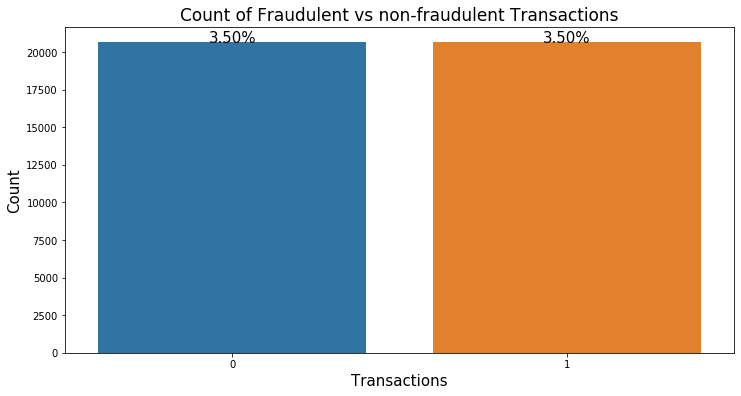

In [41]:
plt.figure(figsize=(12,6))
g = sns.countplot( x = 'isFraud', data=df2)
g.set_title('Count of Fraudulent vs non-fraudulent Transactions', fontsize =17)
g.set_xlabel('Transactions', fontsize = 15)
g.set_ylabel('Count', fontsize=15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2, height + 3, '{:1.2f}%'.format(height/len(train) * 100), ha='center', fontsize=15)

Subsample dataset has equal observations of fraudulent and non fraudulent transations.

### Feature Engineering and Selection

we will take the following steps for feature selection:

    * creating new variables by aggregation
    * dropping categorical variables with more than 60 unique values
    * encode for categorical variables

#### Engineer New Features


In section, we will add new features to model by performing the following:

    * aggregated features
    * drop variables with high collinearity 
    * encoding categorical variables 

##### Time Features

We can incorporate the Transaction delta time by interepting the data as seconds. This will allow us to create day of the week which the transaction occured.

In [42]:
# New feature - day of week in which a transaction 
df2['transaction_day_of_week'] = np.floor((df2['TransactionDT'] / (3600 * 24) - 1) % 7)

In [43]:
# New feature - hour of the day in which a transaction happened.
df2['transaction_hour'] = np.floor(df2['TransactionDT'] / 3600) % 24

##### Transaction Amount per card

We will calculate the average transaction amount for each card.

In [44]:
# New feature - average transaction amount per card 
df2['average_trans_amt_for_card1'] = train['TransactionAmt'] / df2.groupby(['card1'])['TransactionAmt'].transform('mean')
df2['average_trans_amt_for_card4'] = train['TransactionAmt'] / df2.groupby(['card4'])['TransactionAmt'].transform('mean')


#### Visualize New Variables

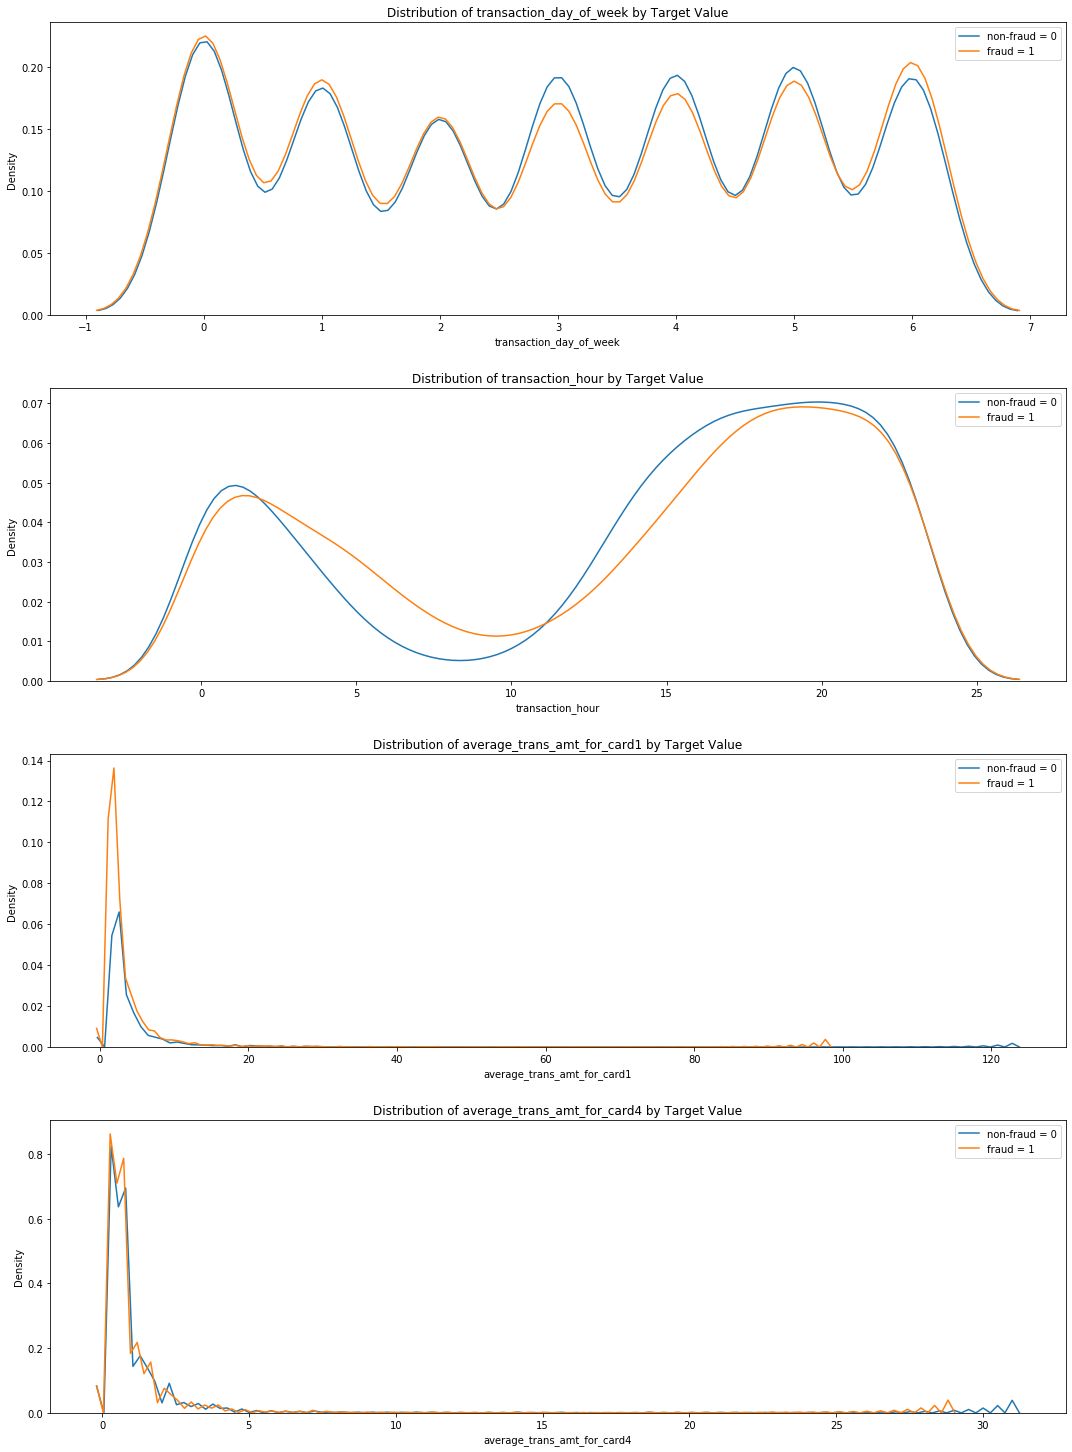

In [45]:

plt.figure(figsize = (15, 30))
# iterate through the new features
for i, feature in enumerate(['transaction_day_of_week', 'transaction_hour', 'average_trans_amt_for_card1', 'average_trans_amt_for_card4',
                            ]):
    
    # create a new subplot for each source
    plt.subplot(6, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df2.loc[df2['isFraud'] == 0, feature], label = 'non-fraud = 0')
    # plot fraud transaction
    sns.kdeplot(df2.loc[df2['isFraud'] == 1, feature], label = 'fraud = 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

#### Feature Selection

In [46]:
df3=df2.copy()
#df2= df3.copy()

I Will use the correlation to drop some features that are high correlated with each other.

In [47]:
threshold = 0.98
    
# Absolute value correlation matrix
corr_matrix = df2[df2['isFraud'].notnull()].corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]


df2 = df2.drop(columns = to_drop)



we will drop the following categorical variables for having more than 60 distinct values.

In [48]:
# Drop categorical columns 
df2.drop(columns=['TransactionDT','P_emaildomain'],
                   axis = 1, inplace=True)

##### Encoding Categorical Variable

Will use label encoding for categorical variable for tree-based models and one-Hot encoding for any other models.

In [49]:
df_le = df2.copy()

In [50]:
#Categorical boolean mask
categorical_feature_mask = df2.dtypes==object

#filter categorical columns using mask and turn it into list
categorical_cols = df2.columns[categorical_feature_mask].tolist()

In [51]:
#instantiate labelencoder object
le = LabelEncoder()

#Apply le on categorical feature columns
df_le[categorical_cols] = df2[categorical_cols].apply(lambda col: le.fit_transform(col))
df_le[categorical_cols].head(10)

,ProductCD,card4,card6
0,0,2,0
1,4,3,0
2,4,2,0
3,4,3,1
4,3,3,1
5,4,3,1
6,0,3,0
7,4,3,0
8,0,3,1
9,4,2,1


In [52]:
df_le.shape

(41326, 169)

In [53]:
#Get dummies df
df_db = pd.get_dummies(df2, prefix_sep = '_', drop_first=True)
df_db.shape

(41326, 174)

In [54]:
df_le.to_csv(r'H:\Clean_df_le.csv', header=True, index=False)
df_db.to_csv(r'H:\Clean_df_db.csv', header=True, index=False)